# Notebook configuration

In [1]:
run_number    = 4365
save_plots    = False
outputfolder  = "plots/{}/".format(run_number)
corr_filename = "merged_corrections.h5"
inputfilename = "/home/brais/Documents/Next/Na/data/{0}/dst_{0}.root.h5".format(run_number)

Zrange        =    0, 600
XYrange       = -198, 198
Rrange        =    0, max(XYrange)
Prange        = -3.2, 3.2  
Erange_raw    =    0, 2e5
Erange_zcorr  =  5e3, 2e5
Erange_xycorr =  5e3, 2e5
Erange_XR     =  6e3, 12e3
Qrange        =    0, 40e2

S1Erange      =    0, 250
S1Wrange      =    0, 300
S1Hrange      =    0, 400
S2Wrange      =    0, 40
S2Hrange      =    0, 50e3
NSirange      =    0, 30

Zrange_LT     =   50, 350
nX, nY        =   50,  50

# Na analysis

In [2]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

import invisible_cities.core.core_functions as coref
import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.dst_functions  as dstf
import invisible_cities.io  .dst_io         as dstio
import invisible_cities.reco.corrections    as corrf

from icaro.core.hst_functions import hist
from icaro.core.hst_functions import hist2d
from icaro.core.hst_functions import pdf
from icaro.core.hst_functions import labels
from icaro.core.hst_functions import hist2d_profile
from icaro.core.hst_functions import covariance
from icaro.core.hst_functions import resolution
from icaro.core.hst_functions import gausstext
from icaro.core.hst_functions import shift_to_bin_centers
from icaro.core.hst_functions import save_to_folder

from copy import copy

pi   = np.pi
save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Tue Jun 27 18:41:04 2017


#### General plotting options

In [3]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

### Useful functions

In [71]:
two_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) + fitf.gauss(x, *args[3:-1])+args[-1]
one_gauss = lambda x, *args: fitf.gauss(x, *args[:3]) +args[-1]

def plot_map(xy_map, run=""):
    x , y  = xy_map._xs
    x0, y0 = np.min(x) - np.diff(x)[0]/2, np.min(y) - np.diff(y)[0]/2
    x1, y1 = np.max(x) + np.diff(x)[0]/2, np.max(y) + np.diff(y)[0]/2
    f      = xy_map._fs
    u      = xy_map._us
    x, y   = np.repeat(x, y.size), np.tile(y, x.size)

    plt.figure(figsize=(20,8))

    plt.subplot(1, 2, 1)
    hist2d(x, y, f.shape, ((x0, x1), (y0, y1)), weights=f.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction factor")
    labels("x (mm)", "y (mm)", str(run))

    plt.subplot(1, 2, 2)
    hist2d(x, y, u.shape, ((x0, x1), (y0, y1)), weights=u.flatten(), new_figure=False)
    plt.colorbar().set_label("Correction uncertainty")
    labels("x (mm)", "y (mm)", str(run))
    
def profile_and_scatter(x, y, z, nbin, *args, **kwargs):
    """
    Create a figure and then a scatter plot
    """
    plt.figure()
    x, y, z, ze = fitf.profileXY(x, y, z, *nbin, *args, **kwargs)
    x_ = np.repeat(x, x.size)
    y_ = np.tile  (y, y.size)
    z_ = z.flatten()
    return (x, y, z, ze), plt.scatter(x_, y_, c=z_, marker="s"), plt.colorbar()

# Read data

In [36]:
full = dstf.load_dst(inputfilename, "DST", "Events")
full = full[full.R<max(Rrange)] # soft radial cut to reduce badly reconstructed events
print(len(full))
full.head()

10027


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
0,1,1.498310e+09,0,1,150.0,21.257883,100.382291,200125.0,19.962000,17383.171875,...,248812.5,51,48.6875,48.6875,-159.559157,-94.372680,185.378876,-2.607477,13.569714,13.131736
1,2,1.498310e+09,0,1,100.0,10.002184,40.615066,200125.0,14.086750,4171.851074,...,741387.5,17,541.2625,541.2625,-70.234199,39.050872,80.360521,2.634147,10.189235,9.402008
2,5,1.498310e+09,0,2,175.0,19.360849,101.710817,200125.0,13.884375,7244.929199,...,585362.5,23,385.2375,385.2375,78.540507,2.145065,78.569794,0.027305,9.941424,10.694994
3,5,1.498310e+09,1,2,175.0,19.360849,101.710817,200125.0,11.934812,3312.253662,...,659612.5,14,459.4875,459.4875,132.214141,99.206779,165.295384,0.643725,9.110193,9.081401
5,7,1.498310e+09,1,2,100.0,12.115897,49.987983,200125.0,12.641250,3112.531738,...,580287.5,16,380.1625,380.1625,149.519724,-116.705143,189.674032,-0.662758,9.325075,9.164627


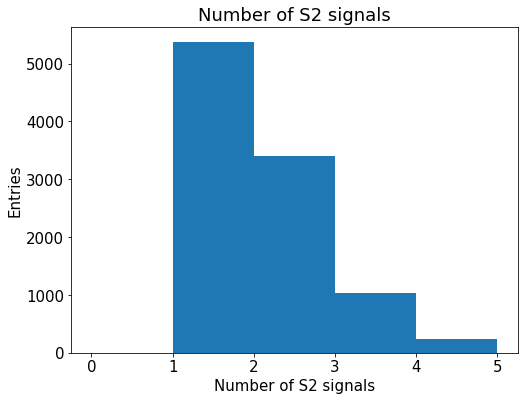

In [7]:
hist(full.nS2, 5, (0, 5))
labels("Number of S2 signals", "Entries", "Number of S2 signals")
save("NS2")

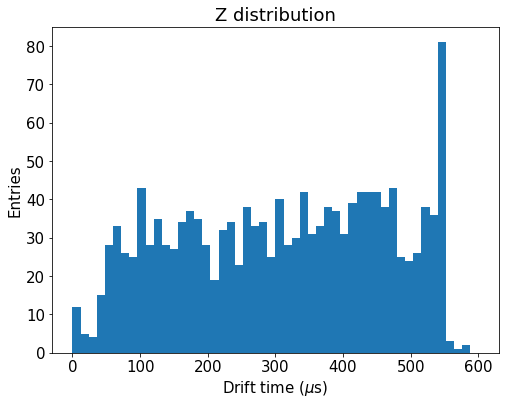

In [8]:
hist(full[full.S2e<10e3].Z, 50, Zrange)
labels("Drift time ($\mu$s)", "Entries", "Z distribution")

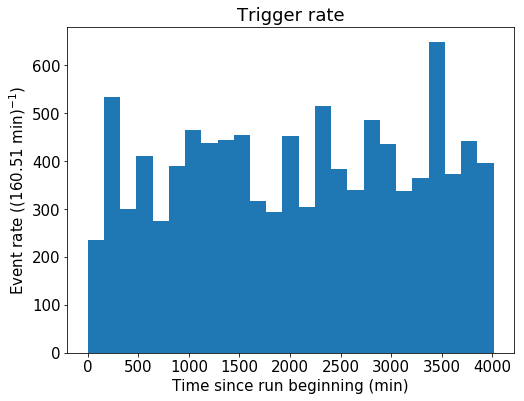

In [9]:
T       = full.time.values / 60
T      -= np.min(T)
 
y, x, _ = hist(T, 25, (np.min(T), np.max(T)))
labels("Time since run beginning (min)",
       "Event rate (({:.2f} min)$^{{-1}}$)".format(np.diff(x)[0]), "Trigger rate")

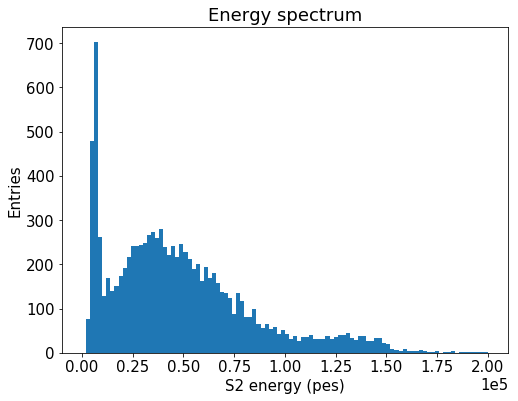

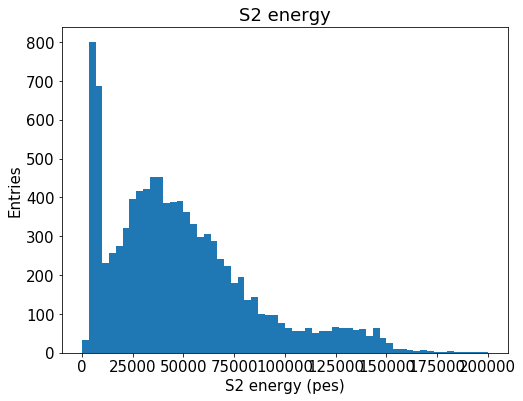

In [116]:
hist(full.S2e, 100, (0, 200e3))
labels("S2 energy (pes)", "Entries", "Energy spectrum")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
hist(full.S2e, 60, Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")

# S1 energy

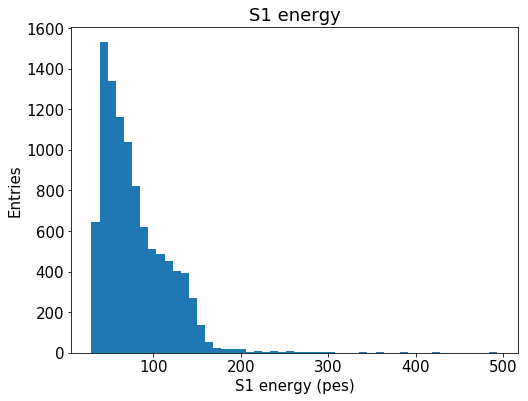

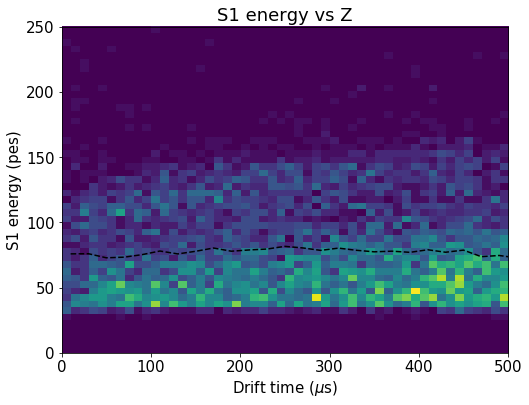

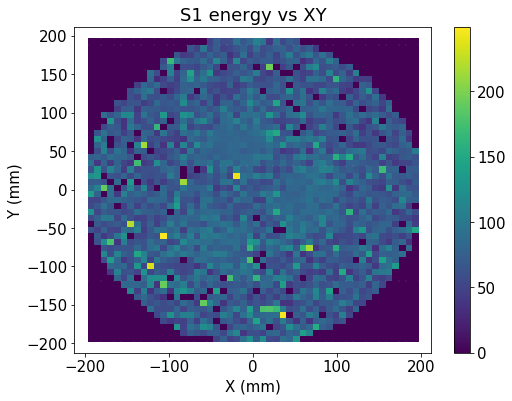

In [99]:
sel_PP = fitf.in_range(full.S2e, 0, 1000e5)

hist(full[sel_PP].S1e, 50)
labels("S1 energy (pes)", "Entries", "S1 energy")
save("S1energy")

hist2d(full[sel_PP].Z, full[sel_PP].S1e, (50, 50), range=([0,500], S1Erange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1e, 30, xrange=Zrange, yrange=S1Erange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 energy (pes)", "S1 energy vs Z")
save("S1energyvsZ")

sel_Z   = fitf.in_range(full.Z, 0, 500)
sel_nS2 = full.nS2=1

sel = sel_Z & sel_nS2 & sel_E
profile_and_scatter(full[sel_PP].X.values, full[sel_PP].Y.values, full[sel_PP].S1e.values, [50,50]);
labels("X (mm)", "Y (mm)", "S1 energy vs XY")
save("S1energyvsXY")


# S1 width

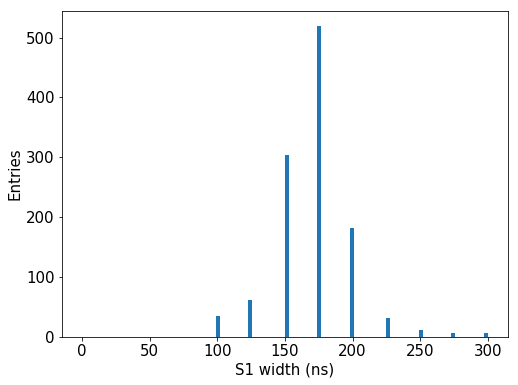

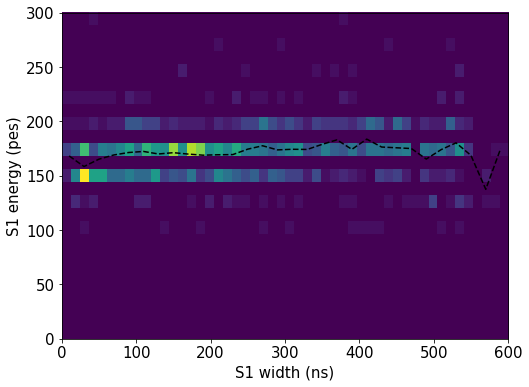

In [103]:
nb = max(S1Wrange)//25
hist(full[sel_PP].S1w, 100, S1Wrange)
labels("S1 width (ns)", "Entries")
save("S1width")

hist2d(full[sel_PP].Z, full[sel_PP].S1w, (50, 25), range=(Zrange, S1Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1w, 30, xrange=Zrange, yrange=S1Wrange)
plt.plot(x, y, profOpt)

labels("S1 width (ns)", "S1 energy (pes)")
save("S1widthvsZ")

# S1 height

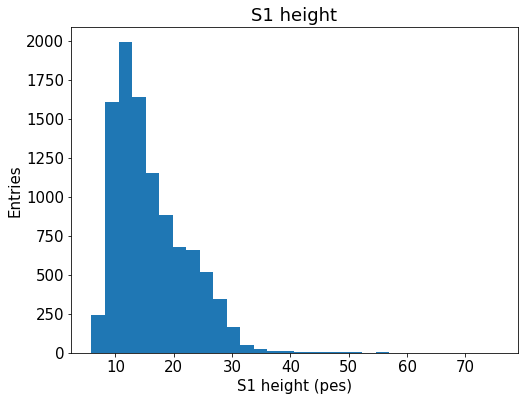

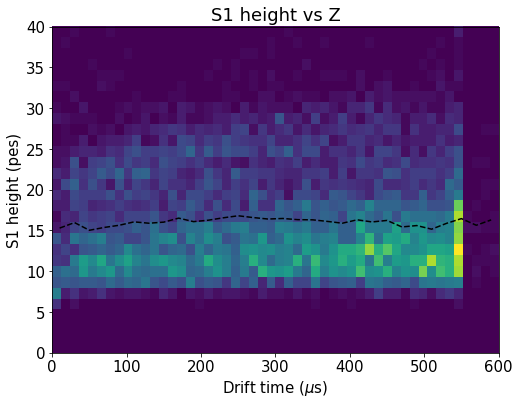

In [101]:
hist(full[sel_PP].S1h, 30)
labels("S1 height (pes)", "Entries", "S1 height")
save("S1height")

hist2d(full[sel_PP].Z, full[sel_PP].S1h, (50, 30), range=(Zrange, [0,40]))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S1h, 30, xrange=Zrange, yrange=S1Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1 height (pes)", "S1 height vs Z")
save("S1heightvsZ")

# S1 peak to area ratio

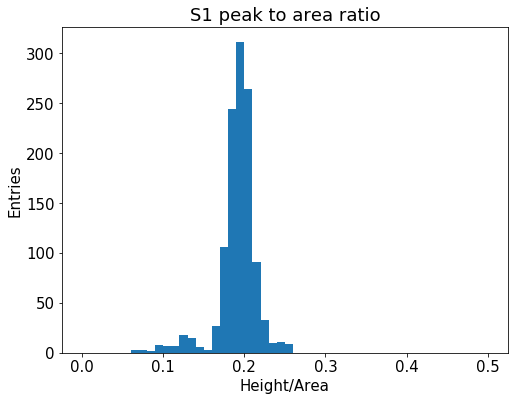

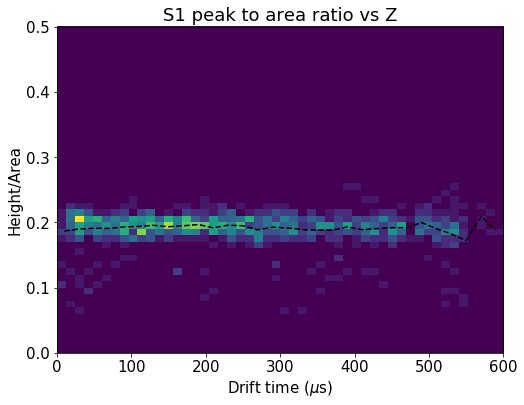

In [84]:
S1r    = full[sel_PP].S1h/full[sel_PP].S1e
_range = 0, 0.5

hist(S1r, 50, range=_range)
labels("Height/Area", "Entries", "S1 peak to area ratio")
save("S1Peak2Area")

hist2d(full[sel_PP].Z, S1r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S1r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S1 peak to area ratio vs Z")
save("S1ratiovsZ")

# S2 energy

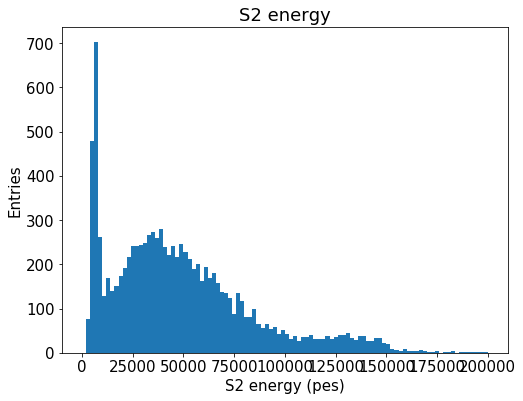

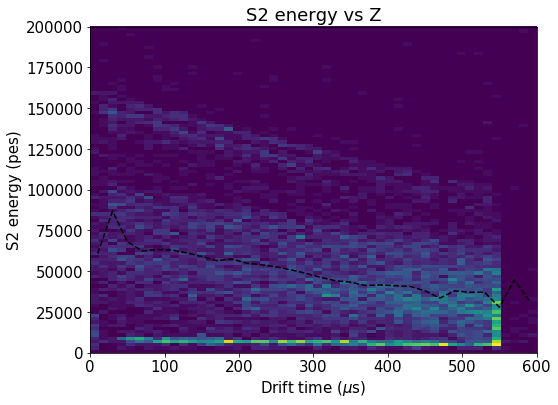

In [15]:
hist(full.S2e, 100, range=Erange_raw)
labels("S2 energy (pes)", "Entries", "S2 energy")
save("S2energy")

hist2d(full.Z, full.S2e, (50, 100), range=(Zrange, Erange_raw))
x, y, _ = fitf.profileX(full.Z, full.S2e, 30, xrange=Zrange, yrange=Erange_raw)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 energy vs Z")
save("S2energyvsZ")

# S2 width

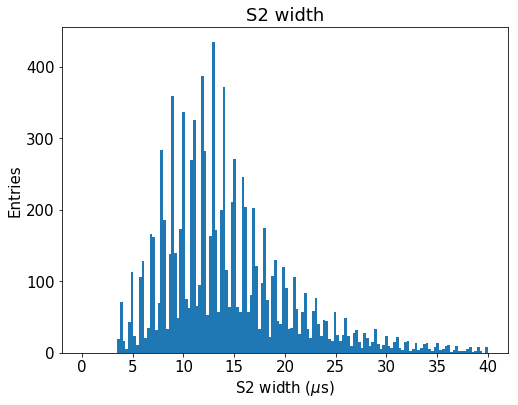

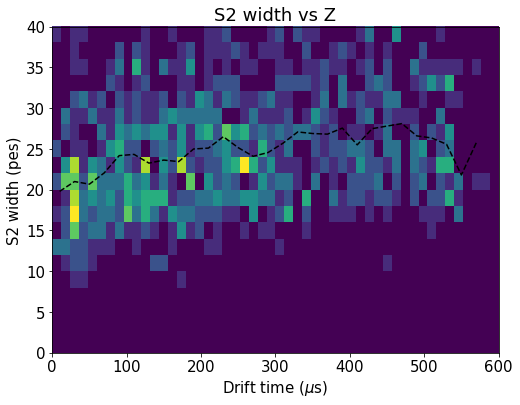

In [104]:
hist(full.S2w, 150, range=S2Wrange)
labels("S2 width ($\mu$s)", "Entries", "S2 width")
save("S2width")

hist2d(full[sel_PP].Z, full[sel_PP].S2w, (50, 20), range=(Zrange, S2Wrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2w, 30, xrange=Zrange, yrange=S2Wrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 width (pes)", "S2 width vs Z")
save("S2widthvsZ")

# S2 height

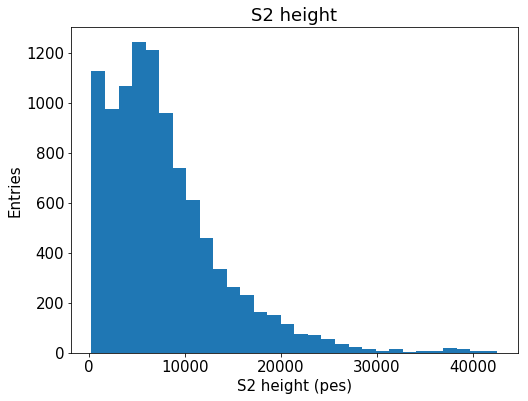

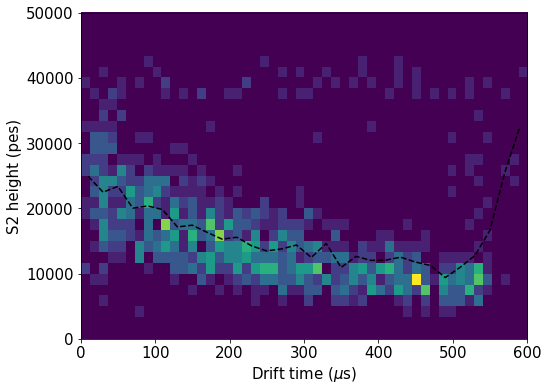

In [106]:
hist(full.S2h, 30)
labels("S2 height (pes)", "Entries", "S2 height")
save("S2height")

hist2d(full[sel_PP].Z, full[sel_PP].S2h, (50, 30), range=(Zrange, S2Hrange))
x, y, _ = fitf.profileX(full[sel_PP].Z, full[sel_PP].S2h, 30, xrange=Zrange, yrange=S2Hrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 height (pes)")
save("S2heightvsZ")

# S2 peak to area ratio

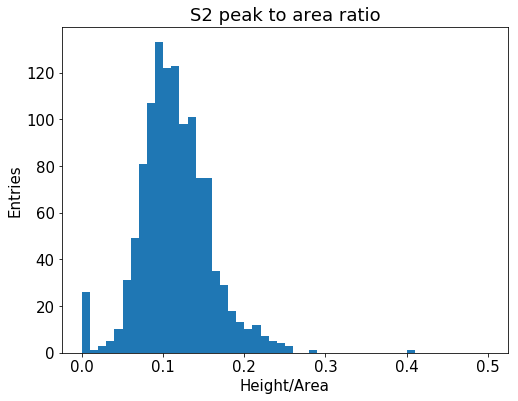

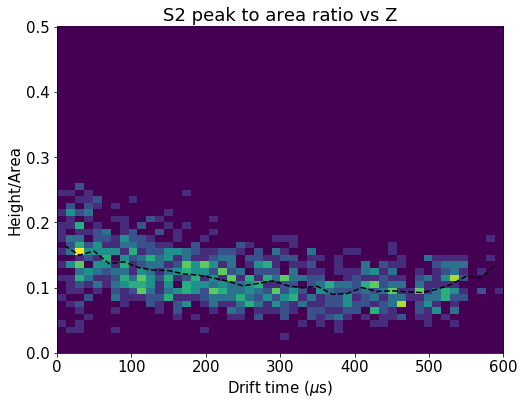

In [107]:
_range = 0, 0.5

S2r = full[sel_PP].S2h/full[sel_PP].S2e

hist(S2r, 50, range=_range)
labels("Height/Area", "Entries", "S2 peak to area ratio")
save("S2Peak2Area")

hist2d(full[sel_PP].Z, S2r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full[sel_PP].Z, S2r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "Height/Area", "S2 peak to area ratio vs Z")
save("S2ratiovsZ")

# S2 vs S1

'\nsel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)\nc = covariance(full[sel].S1e, full[sel].S2e)\nprint(*c)\nlabels("S1 energy (pes)", "S2 energy (pes)")\nsave("S2vsS1")\n'

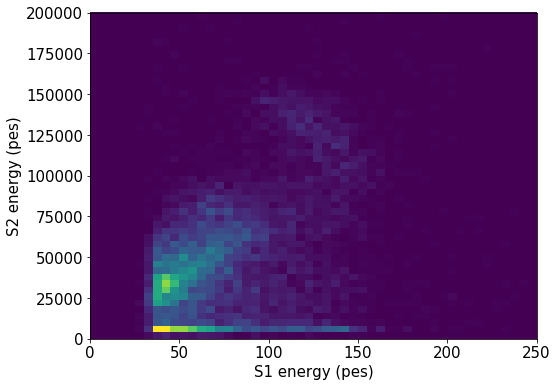

In [110]:
Energy = full.S2e*Zcorr(full.Z.values).value* xy_map(data.X.values,data.Y.values).value
sel_PP  = Energy>0.125000

hist2d(full[sel_PP].S1e, full[sel_PP].S2e, (50, 50), range=(S1Erange, Erange_raw))
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
#x, y, _ = fitf.profileX(full.S1e, full.S2e, 30, xrange=S1Erange, yrange=Erange_raw)
#plt.plot(x, y, profOpt)
"""
sel = coref.in_range(full.S1e, *S1Erange) & coref.in_range(full.S2e, *Erange_raw)
c = covariance(full[sel].S1e, full[sel].S2e)
print(*c)
labels("S1 energy (pes)", "S2 energy (pes)")
save("S2vsS1")
"""

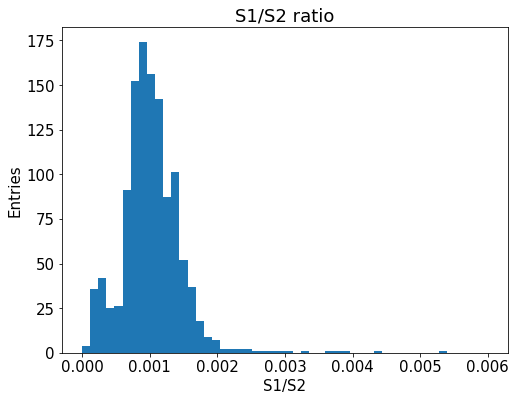

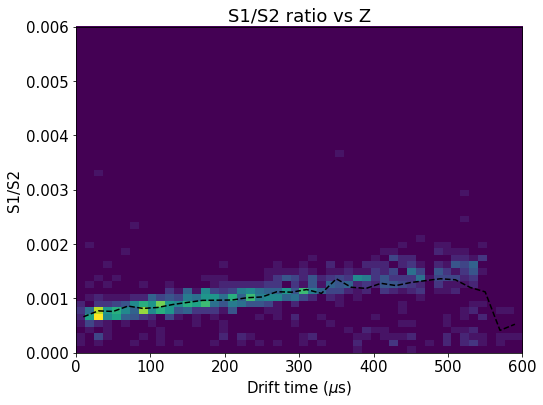

In [64]:
_range = 0, 0.006

S12r = full[sel].S1e/full[sel].S2e

hist(S12r, 50, range=_range)
labels("S1/S2", "Entries", "S1/S2 ratio")
save("S12ratio")

hist2d(full[sel].Z, S12r, (50, 50), range=(Zrange, _range))
x, y, _ = fitf.profileX(full.Z, S12r, 30, xrange=Zrange, yrange=_range)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S1/S2", "S1/S2 ratio vs Z")
save("S12ratiovsZ")

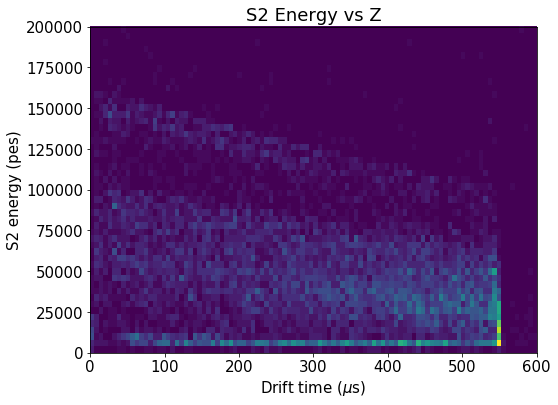

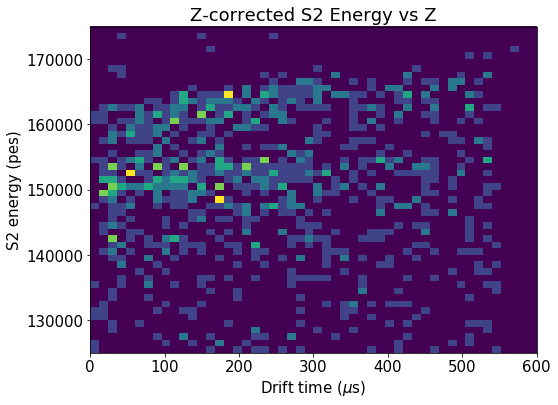

In [152]:
data = full
hist2d(data.Z, data.S2e, (100, 50), range=(Zrange, [0,2e5]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "S2 Energy vs Z")
save("S2energyvsZ_fiducial")

data = full
hist2d(data.Z, data.S2e* Zcorr(data.Z.values).value, (50, 50), range=(Zrange, [1.25e5,1.75e5]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])


labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected S2 Energy vs Z")
save("S2energyvsZ_fiducial")

# Lifetime calculation

In [21]:
fid = full
fid = fid[(fid.R < 100)] # Fiducialize in order to reduce geometrical effects
print("Ratio:", len(fid)/len(full))
fid.head()

Ratio: 0.5180013962301785


,event,time,peak,nS2,S1w,S1h,S1e,S1t,S2w,S2h,...,S2t,Nsipm,DT,Z,X,Y,R,Phi,Xrms,Yrms
1,2,1.498310e+09,0,1,100.0,10.002184,40.615066,200125.0,14.086750,4171.851074,...,741387.5,17,541.2625,541.2625,-70.234199,39.050872,80.360521,2.634147,10.189235,9.402008
2,5,1.498310e+09,0,2,175.0,19.360849,101.710817,200125.0,13.884375,7244.929199,...,585362.5,23,385.2375,385.2375,78.540507,2.145065,78.569794,0.027305,9.941424,10.694994
6,8,1.498310e+09,0,2,100.0,12.894278,52.908075,200125.0,12.251250,12904.041016,...,437762.5,32,237.6375,237.6375,82.227898,-10.735976,82.925801,-0.129829,11.186396,10.705046
7,8,1.498310e+09,1,2,100.0,12.894278,52.908075,200125.0,6.990094,1609.015015,...,472987.5,3,272.8625,272.8625,82.398036,-10.280840,83.036932,-0.124129,4.411598,5.019621
8,9,1.498310e+09,0,1,100.0,7.701235,32.963969,200125.0,5.365828,22907.970703,...,207062.5,24,6.9375,6.9375,-65.596573,-17.106797,67.790507,-2.886487,9.268251,9.682888


# S2 energy fiducialized

Energy at z=0 = 8538.9 +- 68.9
Lifetime      = 1061.5 +- 31.5
Chi2          = 2.05          


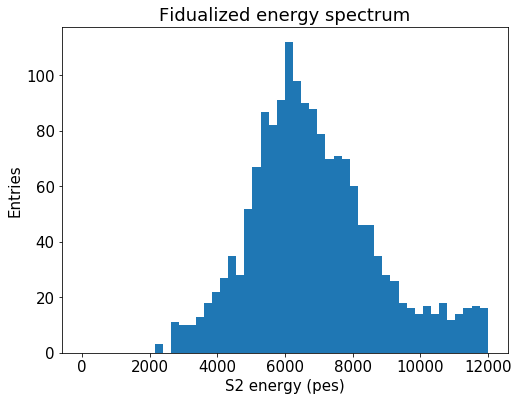

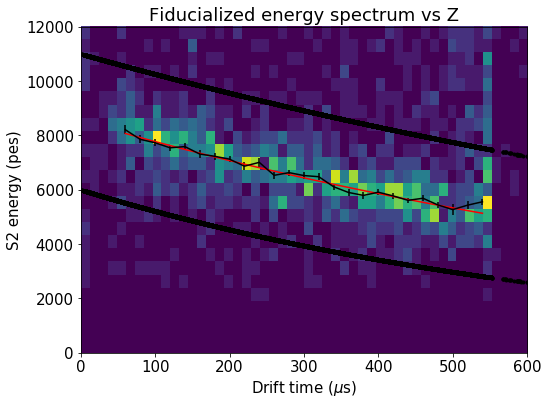

In [115]:
data = full
hist(data.S2e, 50, range=[0,12e3])
labels("S2 energy (pes)", "Entries", "Fidualized energy spectrum")
save("S2energy_fiducial")

low_cut   =  6000 * np.exp(-0.0014*data.Z.values)
high_cut  = 11000 * np.exp(-0.0007*data.Z.values)
sel       = coref.in_range(data.S2e.values, low_cut, high_cut) # remove low and high E background

hist2d(data.Z, data.S2e, (50, 25), range=(Zrange, [0,12e3]))
x, y, u_y = fitf.profileX(data.Z[sel], data.S2e[sel], 25, xrange=(50,550), yrange=[0,12e3])

plt.errorbar(x, y, yerr=u_y, fmt='k')#, profOpt)
plt.plot(data.Z.values,  low_cut, "k.")
plt.plot(data.Z.values, high_cut, "k.")

seed = 9000,-981#np.max(y), (x[15] - x[5])/np.log(y[15]/y[5])
f    = fitf.fit(fitf.expo, x, y, seed, fit_range=(50,500), sigma=u_y)

plt.plot(x, f.fn(x), fitOpt)
print("Energy at z=0 = {:.1f} +- {:.1f}".format( f.values[0], f.errors[0]))
print("Lifetime      = {:.1f} +- {:.1f}".format(-f.values[1], f.errors[1]))
print("Chi2          = {:.2f}          ".format(f.chi2))

labels("Drift time ($\mu$s)", "S2 energy (pes)", "Fiducialized energy spectrum vs Z")
save("S2energyvsZ_fiducial")

Zcorr = corrf.LifetimeCorrection(-f.values[1], f.errors[1])

# Correction by attachment

[  8.48059076e+04   8.93892746e+03   5.11184895e+02   1.00000000e+04
   1.04039233e+04   2.52731282e+02   5.38342690e+00]
[  2.48173581e+04   3.43815543e+01   7.86816097e+01   1.12757225e+04
   1.20700125e+02   1.73173984e+02   1.07599742e+01]


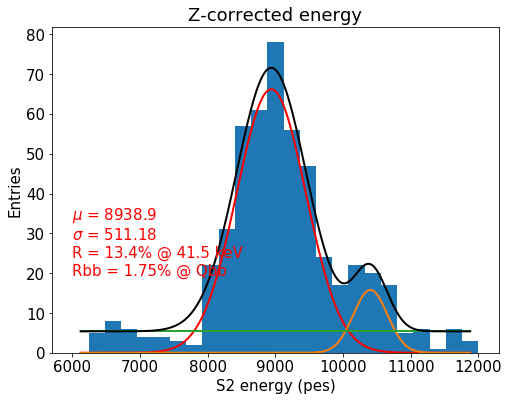

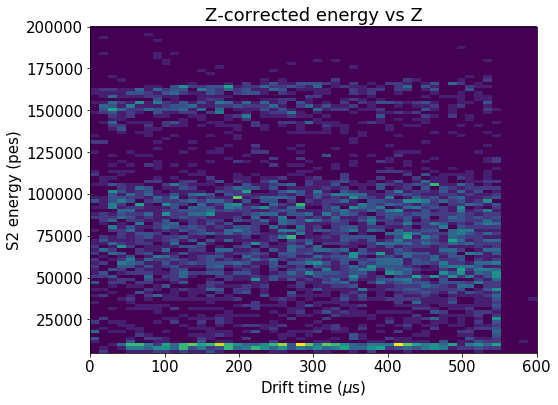

In [149]:
Efid_zcorr = fid.S2e.values * Zcorr(fid.Z.values).value

y, x, _ = hist(Efid_zcorr, 25, range=Erange_XR)

seed = 1e4,  9000, 300, 1e3, 10500, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e4, 11000, 700, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(8e3,11e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+1e3, 1*max(y)/4, gausstext(f.values, 41.5), color=fitOpt)

labels("S2 energy (pes)", "Entries", "Z-corrected energy")
save("S2energyCorr_fiducial")

hist2d(fid.Z.values, Efid_zcorr, (50, 100), range=(Zrange, Erange_zcorr))
labels("Drift time ($\mu$s)", "S2 energy (pes)", "Z-corrected energy vs Z")
save("S2energyCorrvsZ_fiducial")

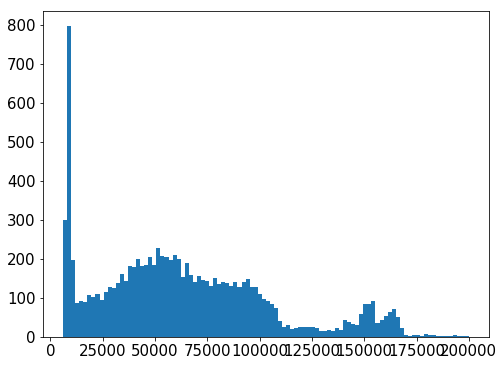

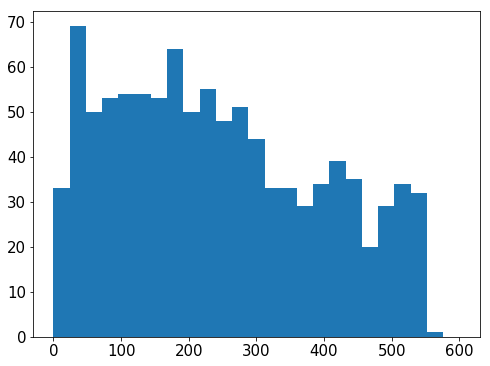

In [24]:
E_zcorr = full.S2e.values * Zcorr(full.Z.values).value

SelE = coref.in_range(E_zcorr,1.2e5,1.75e5)

y, x, _ = hist(E_zcorr, 100, range=[6e3, 2e5]);


hist(full.Z[SelE],25, range=(0,600))


tokeep = copy(full)
tokeep.S2e = E_zcorr
f = tb.open_file("dst_{0}_corr.root.h5".format(run_number),'w')
f.flush()
f.close()

# Tracking

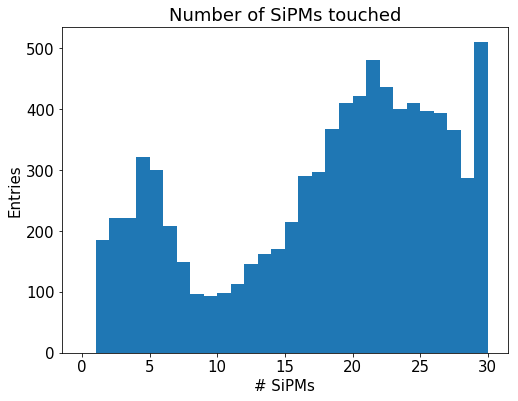

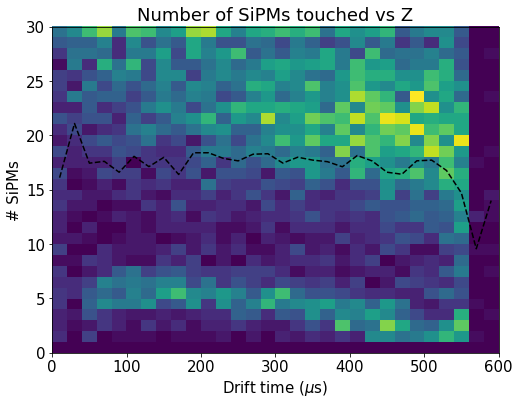

In [25]:
hist(full.Nsipm, max(NSirange), NSirange)
labels("# SiPMs", "Entries", "Number of SiPMs touched")
save("Nsipm")

hist2d(full.Z, full.Nsipm, (30, max(NSirange)), range=(Zrange, NSirange))
x, y, _ = fitf.profileX(full.Z, full.Nsipm, 30, xrange=Zrange, yrange=NSirange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "# SiPMs", "Number of SiPMs touched vs Z")
save("NsipmvsZ")


# Na distribution

In [94]:
E_zcorr = full.S2e.values #* Zcorr(full.Z.values).value
sel     = coref.in_range(E_zcorr, 1.25e5, 1.75e5)
sel     = sel & coref.in_range(full.Z, 300     , 500   )
Kr      = full   [sel]
E_zcorr = E_zcorr[sel]

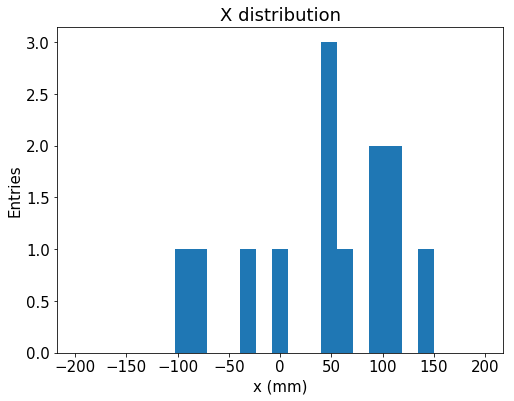

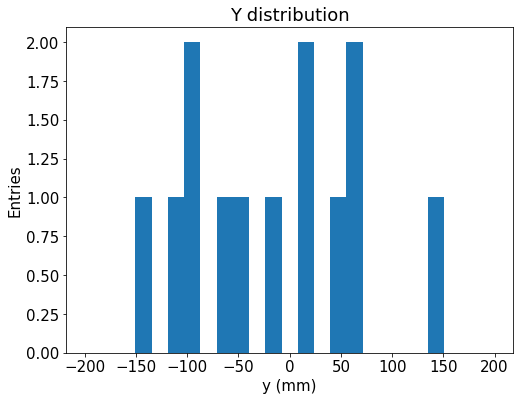

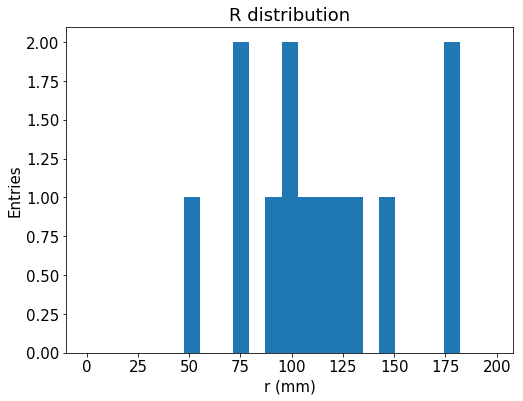

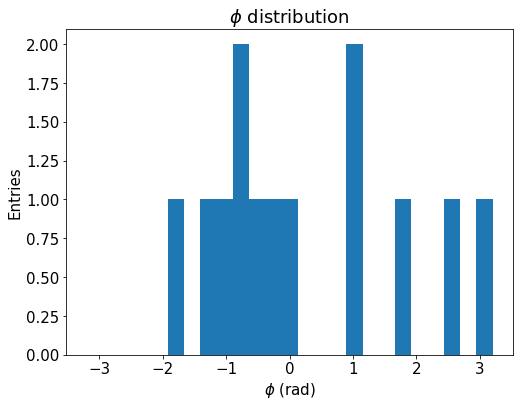

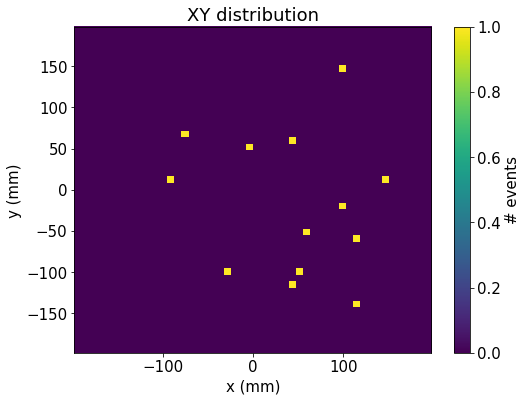

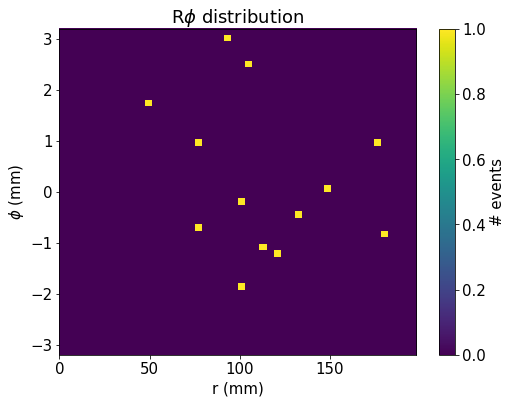

In [95]:
hist(Kr.X, 25, range=XYrange)
labels("x (mm)", "Entries", "X distribution")
save("X")

hist(Kr.Y, 25, range=XYrange)
labels("y (mm)", "Entries", "Y distribution")
save("Y")

hist(Kr.R, 25, range=Rrange)
labels("r (mm)", "Entries", "R distribution")
save("R")

hist(Kr.Phi, 25, range=Prange)
labels("$\phi$ (rad)", "Entries", "$\phi$ distribution")
save("Phi")

nXY, xs, ys, _ = \
hist2d(Kr.X, Kr.Y, (nX, nY), range=(XYrange, XYrange))
plt.colorbar().set_label("# events")
labels("x (mm)", "y (mm)", "XY distribution")
save("XY")

hist2d(Kr.R, Kr.Phi, (nX, nY), range=(Rrange, Prange))
plt.colorbar().set_label("# events")
labels("r (mm)", "$\phi$ (mm)", "R$\phi$ distribution")
save("RPhi")

# Tracking charge

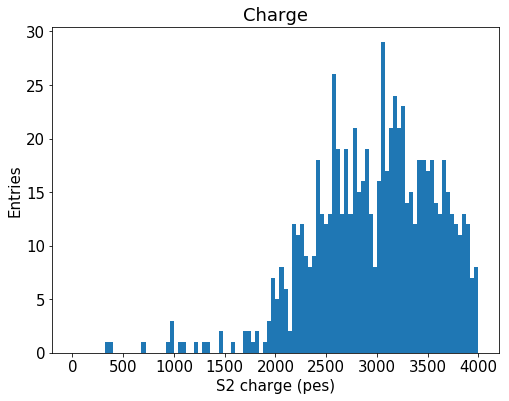

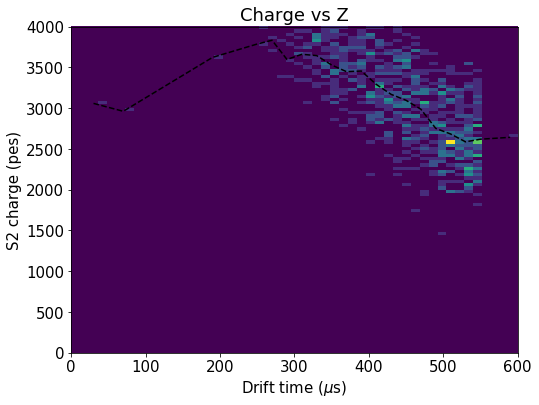

In [28]:
hist(Kr.S2q, 100, range=Qrange)
labels("S2 charge (pes)", "Entries", "Charge")
save("S2charge")

hist2d(Kr.Z, Kr.S2q, (50, 100), range=(Zrange, Qrange))
x, y, _ = fitf.profileX(Kr.Z, Kr.S2q, 30, xrange=Zrange, yrange=Qrange)
plt.plot(x, y, profOpt)

labels("Drift time ($\mu$s)", "S2 charge (pes)", "Charge vs Z")
save("S2chargevsZ")

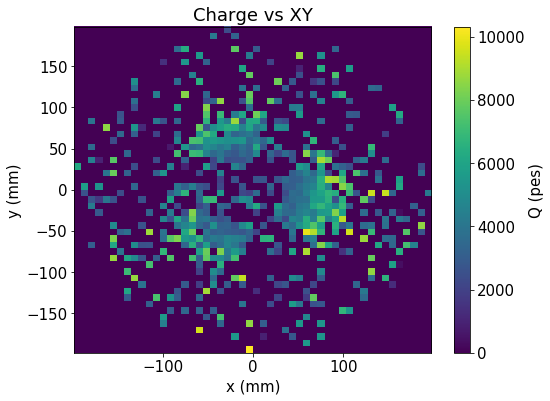

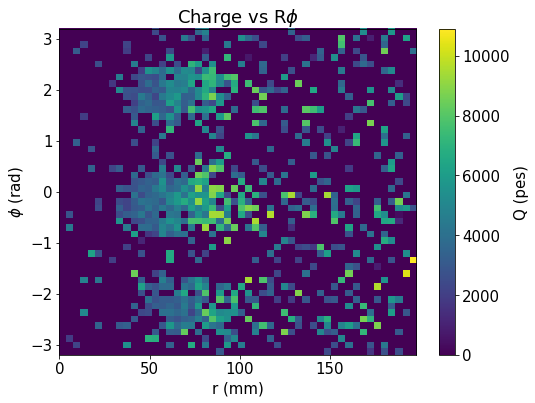

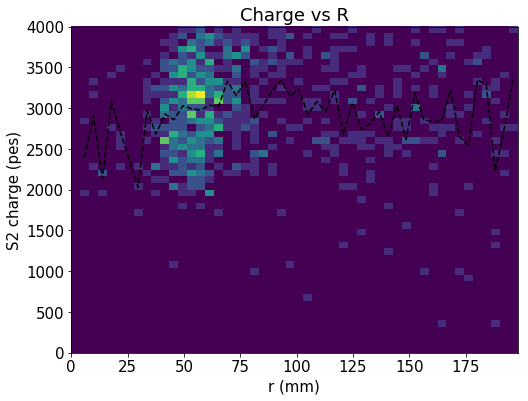

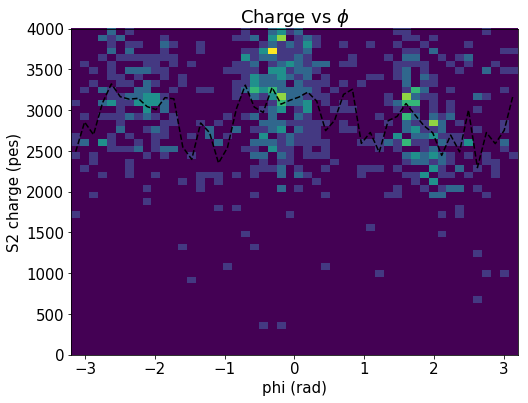

In [29]:
_, _, cb = hist2d_profile(Kr.X, Kr.Y, Kr.S2q, nX, nY, XYrange, XYrange)
cb.set_label("Q (pes)")
labels("x (mm)", "y (mm)", "Charge vs XY")
save("QvsXY")

_, _, cb = hist2d_profile(Kr.R, Kr.Phi, full.S2q, nX, nY, Rrange, Prange)
cb.set_label("Q (pes)")
labels("r (mm)", "$\phi$ (rad)", "Charge vs R$\phi$")
save("QvsRPhi")

hist2d(Kr.R, Kr.S2q, (50, 50), (Rrange, Qrange))
x, y, _ = fitf.profileX(Kr.R, Kr.S2q, 50, xrange=Rrange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("r (mm)", "S2 charge (pes)", "Charge vs R")
save("QvsR")

hist2d(Kr.Phi, Kr.S2q, (50, 50), range=(Prange, Qrange))
x, y, _ = fitf.profileX(Kr.Phi, Kr.S2q, 50, xrange=Prange, yrange=Qrange)
plt.plot(x, y, profOpt)
labels("phi (rad)", "S2 charge (pes)", "Charge vs $\phi$")
save("QvsPhi")

# Energy vs position

In [30]:
xy_map = dstf.load_xy_corrections(corr_filename)

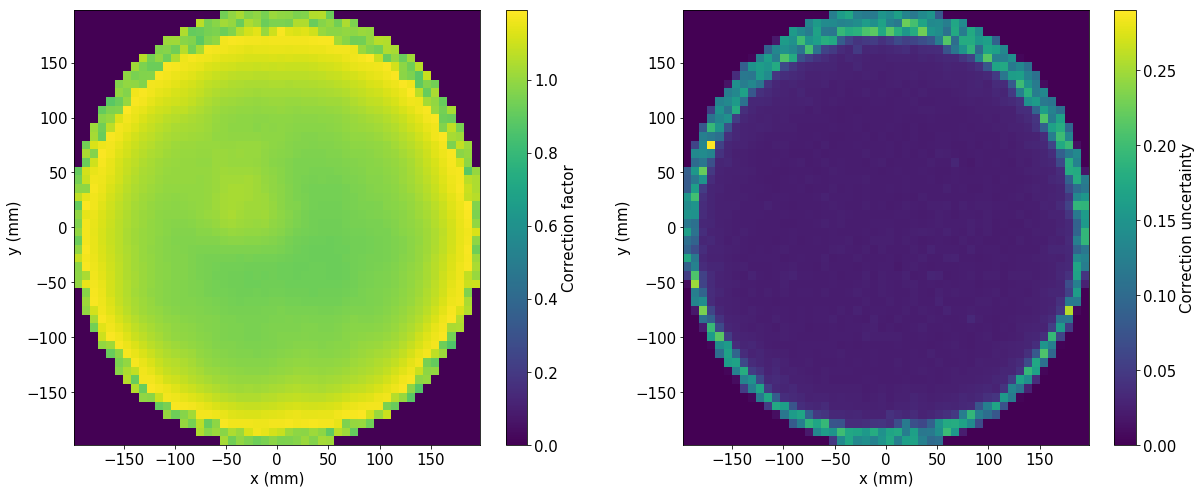

In [31]:
plot_map(xy_map)

[  8.65920942e+04   8.52291964e+03   2.85810252e+02   2.37110768e+04
   9.71570303e+03   3.74622309e+02   7.15409801e+00]
[  3.20619549e+03   1.01313245e+01   1.07559261e+01   3.93832359e+03
   5.43098701e+01   6.25279848e+01   1.44635469e+00]


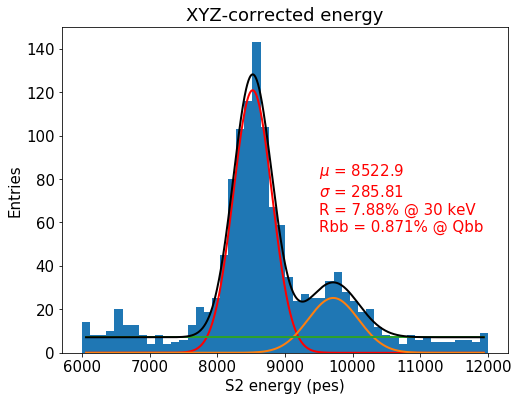

In [134]:
data = full
Efull_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efull_zcorr, 50, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  4.87430243e+04   8.54006717e+03   2.71993397e+02   1.45738606e+04
   9.77173645e+03   3.73954720e+02   1.93016629e+00]
[  1.85973372e+03   9.77469425e+00   1.04542475e+01   2.38378488e+03
   5.16713823e+01   5.96986905e+01   9.08581629e-01]


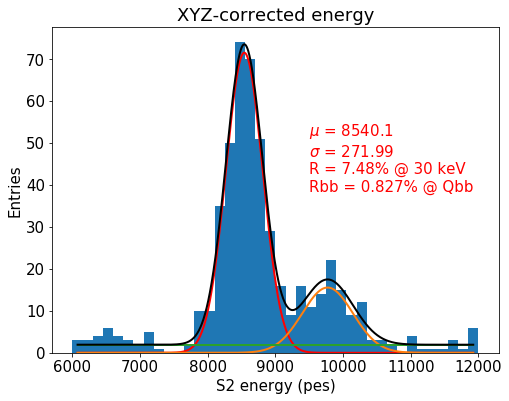

In [135]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value*xy_map(data.X.values,data.Y.values).value

y, x, _ = hist(Efid_zcorr, 40, range=[6e3, 12e3])

seed = 1e4,  9000, 300, 1e3, 10000, 500, 10
low  =  10,  6000,  50, 1e2,  9000,  50, 0 
upp  = 1e8, 10000, 900, 1e5, 11000, 500, 100
f    = fitf.fit(two_gauss, x, y, seed, fit_range=(7.5e3,12e3), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(Erange_zcorr[0]+4.5e3, 1*max(y)/4+20, gausstext(f.values, 30), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  3.76945431e+05   1.51882761e+05   1.38912192e+03   5.47042103e+00]
[  2.21788323e+04   7.93496682e+01   8.46559561e+01   1.62562409e+00]


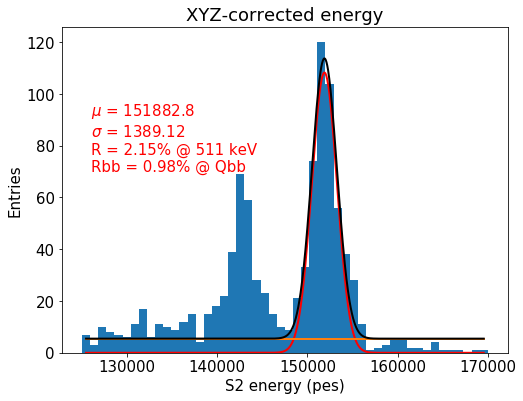

In [137]:
data = full
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value * xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efid_zcorr, 50, range=[1.25e5,1.7e5])

seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10E2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.45e5,1.75e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+30, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

[  3.34458163e+05   1.51918472e+05   1.33786554e+03   5.89444518e+00]
[  2.75507564e+04   8.43523150e+01   1.00521645e+02   2.90990092e+00]


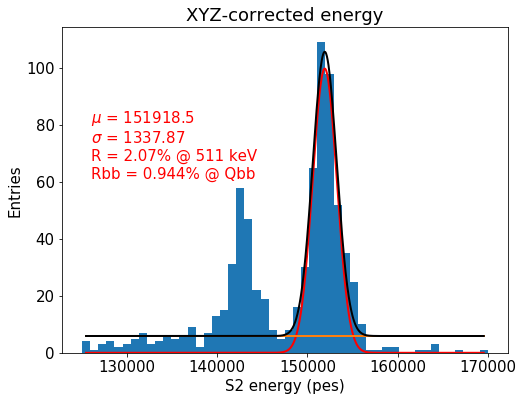

In [141]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value *xy_map(data.X.values,data.Y.values).value
y, x, _ = hist(Efid_zcorr, 50, range=[1.25e5,1.7e5])

seed =  1e4,   1.5e5, 1e3, 10
low  =  1e4,  1.45e5,  10e2, 0 
upp  =  1e8,     2e5, 5e5, 10
f    = fitf.fit(one_gauss, x, y, seed, fit_range=(1.475e5,1.6e5), bounds=(low, upp))
print(f.values)
print(f.errors)


xrange = np.linspace(x[0], x[-1],1000)


plt.plot(xrange, fitf.gauss(xrange, *f.values[:3]), "r-", linewidth=2)
#plt.plot(xrange, fitf.gauss(xrange, *f.values[3:-1]), linewidth=2)
plt.plot(xrange, f.values[-1]*np.ones_like(xrange), linewidth=2)
plt.plot(xrange, f.fn(xrange), "k-", linewidth=2)
plt.text(1.25e5+1e3, 1*max(y)/3+25, gausstext(f.values, 511), color=fitOpt)

labels("S2 energy (pes)", "Entries", "XYZ-corrected energy")
save("S2energyCorr")

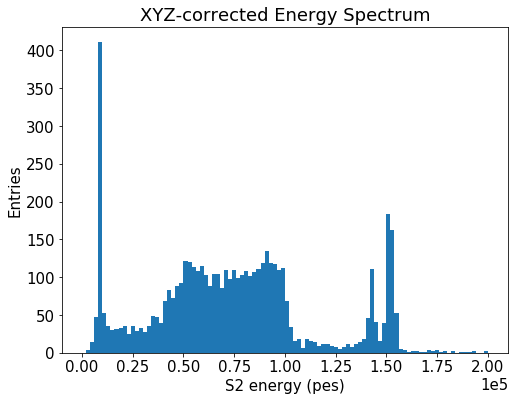

In [120]:
data = fid
Efid_zcorr = data.S2e.values * Zcorr(data.Z.values).value *xy_map(data.X.values,data.Y.values).value

y, x, _ = hist(Efid_zcorr, 100, range=[0,2e5])
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

labels("S2 energy (pes)", "Entries", "XYZ-corrected Energy Spectrum")
save("S2energyCorr")

(0, 198)